# KAGGLE: M5 FORECASTING

https://www.kaggle.com/c/m5-forecasting-accuracy/data

---

## Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

---

## Import data

In [3]:
filename = 'data/sales_train_validation.csv'
df_raw = pd.read_csv(filename)

In [4]:
df_raw.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1


In [5]:
filename = 'data/calendar.csv'
calendar = pd.read_csv(filename, parse_dates=['date'], infer_datetime_format=True, dayfirst=True)

In [6]:
calendar.head(1)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,5_Sat,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0


In [7]:
filename = 'data/sell_prices.csv'
price = pd.read_csv(filename)

In [8]:
price.head(1)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58


---

## Preprocessing

In [9]:
PRODUCT = 1
MIN_PERIOD = pd.to_datetime('01-09-2011', format='%d-%m-%Y')

### Calendar: mapping date <> d

In [10]:
mapping_calendar = calendar[['date', 'd', 'wm_yr_wk', 'weekday', 'month', 'year']].copy()

### Calendar: holidays name, type

In [11]:
holidays = calendar[['d', 'event_name_1']].copy()
holidays.dropna(inplace=True)

In [12]:
filter_holidays = ['SuperBowl', 'ValentinesDay', 'Easter', 'NBAFinalsEnd', 'Thanksgiving', 'Christmas', 'NewYear',
                  "Mother's day", 'NBAFinalsStart','NBAFinalsEnd', "Father's day", 'IndependenceDay', 
                   'Ramadan starts', 'Eid al-Fitr', 'LaborDay', 'ColumbusDay', 'Halloween', 'EidAlAdha']
flag = holidays['event_name_1'].apply(lambda x: x in filter_holidays)
holidays = holidays[flag]
holidays.rename(columns={'event_name_1':'holiday'}, inplace=True)
holidays.head()

,d,holiday
8,d_9,SuperBowl
16,d_17,ValentinesDay
85,d_86,Easter
99,d_100,Mother's day
122,d_123,NBAFinalsStart


### Training data: cut data (get top N products)

In [13]:
df = df_raw.drop(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis=1).copy()
df.set_index('id', inplace=True)

In [14]:
df['total'] = df.sum(axis=1)

In [15]:
df_sorted = df[['total']].sort_values(by='total', ascending=False)

In [16]:
# n = 1
# top_id = [df_sorted.index[i] for i in range(n)]
top_id = df_sorted.index[PRODUCT]
top_id

'FOODS_3_586_TX_2_validation'

In [17]:
df_raw['flag'] = df_raw['id'].apply(lambda x: x in top_id)

In [18]:
df_filter = df_raw[df_raw['flag']]
df_filter.drop('flag', axis=1, inplace=True)
df_filter.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
18055,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,98,85,47,56,...,80,78,102,54,67,57,59,80,100,75


### Training data: drop columns

In [19]:
drop_cols = ['dept_id', 'cat_id', 'state_id']
df_filter.drop(drop_cols, axis=1, inplace=True)

### Unpivot weeks

In [20]:
id_vars = ['id', 'item_id', 'store_id']
df = df_filter.melt(id_vars=id_vars, var_name='d')
df.tail()

,id,item_id,store_id,d,value
1908,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,d_1909,57
1909,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,d_1910,59
1910,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,d_1911,80
1911,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,d_1912,100
1912,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,d_1913,75


### Join date: replace d with dd-mm-yy

In [21]:
df = pd.merge(df, mapping_calendar[['d', 'date', 'wm_yr_wk', 'weekday', 'month', 'year']], how='left', 
              left_on='d', right_on='d')
df['date'] = pd.to_datetime(df['date'])

In [22]:
df.tail(1)

,id,item_id,store_id,d,value,date,wm_yr_wk,weekday,month,year
1912,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,d_1913,75,2016-04-24,11613,6_Sun,4,2016


In [23]:
flag = df['date'] >= MIN_PERIOD
df = df[flag]

### Join date: holidays

In [24]:
df = pd.merge(df, holidays[['d', 'holiday']], how='left', 
              left_on='d', right_on='d')
df['holiday'].fillna(0, inplace=True)
df.drop('d', axis=1, inplace=True)

In [25]:
df.head()

,id,item_id,store_id,value,date,wm_yr_wk,weekday,month,year,holiday
0,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,144,2011-09-01,11131,3_Thu,9,2011,0
1,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,147,2011-09-02,11131,4_Fri,9,2011,0
2,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,177,2011-09-03,11132,5_Sat,9,2011,0
3,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,88,2011-09-04,11132,6_Sun,9,2011,0
4,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,138,2011-09-05,11132,0_Mon,9,2011,LaborDay


### Join prices

In [26]:
df = pd.merge(df, price, how='left', 
              left_on=['item_id', 'store_id', 'wm_yr_wk'], 
              right_on=['item_id', 'store_id', 'wm_yr_wk'])

In [27]:
df.head(1)

,id,item_id,store_id,value,date,wm_yr_wk,weekday,month,year,holiday,sell_price
0,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,144,2011-09-01,11131,3_Thu,9,2011,0,1.48


In [28]:
df.sort_values(by='date', inplace=True)

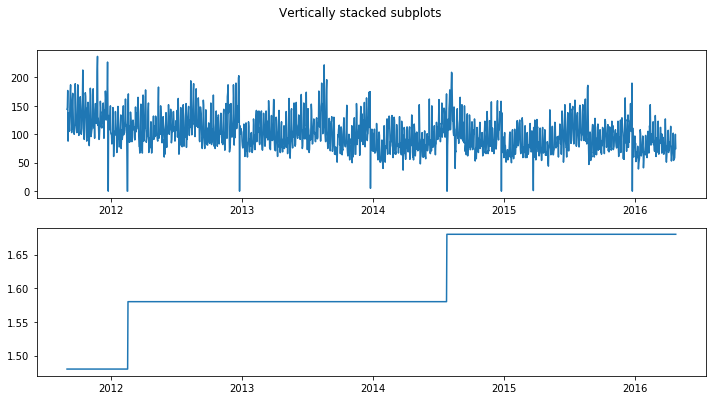

In [29]:
fig, axs = plt.subplots(2, figsize=(12, 6))
fig.suptitle('Vertically stacked subplots')
axs[0].plot(df['date'], df['value'])
axs[1].plot(df['date'], df['sell_price'])
plt.show()

In [30]:
df.tail()

,id,item_id,store_id,value,date,wm_yr_wk,weekday,month,year,holiday,sell_price
1693,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,57,2016-04-20,11612,2_Wed,4,2016,0,1.68
1694,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,59,2016-04-21,11612,3_Thu,4,2016,0,1.68
1695,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,80,2016-04-22,11612,4_Fri,4,2016,0,1.68
1696,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,100,2016-04-23,11613,5_Sat,4,2016,0,1.68
1697,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,75,2016-04-24,11613,6_Sun,4,2016,0,1.68


### Add: weeknum

In [31]:
df['weeknum'] = df['date'].dt.week

---

## Exploratory Data

### Daily Trends

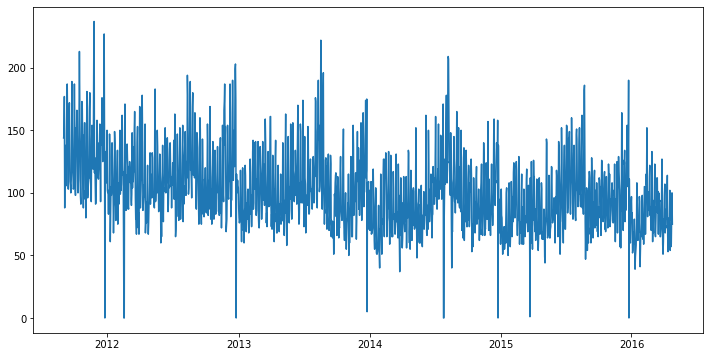

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['value'])
plt.show()

### Sales by year

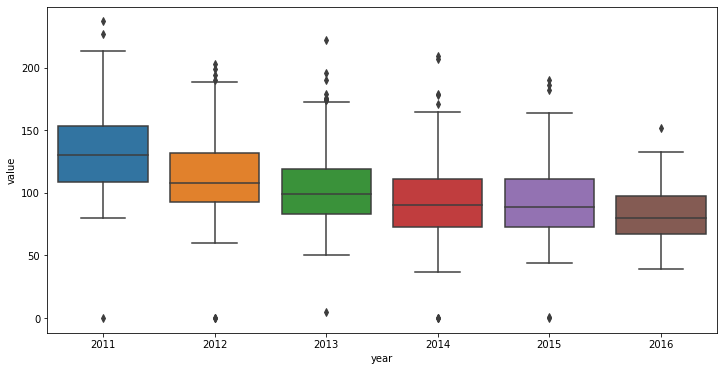

In [33]:
plt.figure(figsize=(12, 6))
flag = df['year'] > 2010
sns.boxplot(x='year', y='value', data=df[flag])
plt.show()

### Sales by month

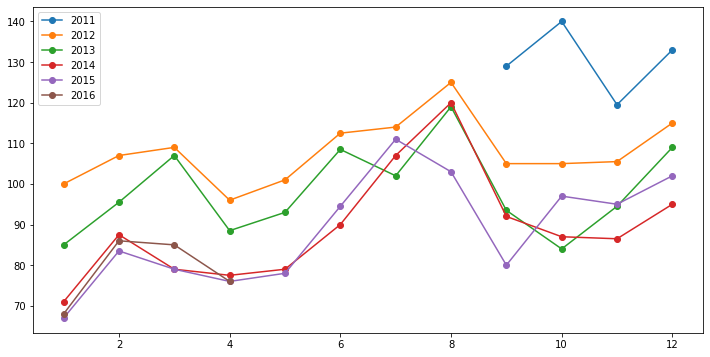

In [34]:
flag = df['year'] > 2010
df_filter = df[flag]
plt.figure(figsize=(12, 6))
for year in df_filter['year'].unique():
    flag_year = df_filter['year'] == year
    agg = df_filter[flag_year].groupby(by='month').median()
    plt.plot(agg['value'], '-o', label=year)
plt.legend()

### Sales by weekday

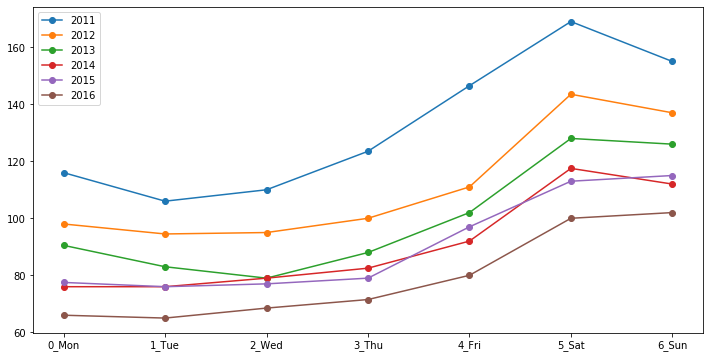

In [35]:
flag = df['year'] > 2010
df_filter = df[flag]
plt.figure(figsize=(12, 6))
for year in df_filter['year'].unique():
    flag_year = df_filter['year'] == year
    agg = df_filter[flag_year].groupby(by='weekday').median()
    plt.plot(agg['value'], '-o', label=year)
plt.legend()
plt.show()

### Sales Distribution

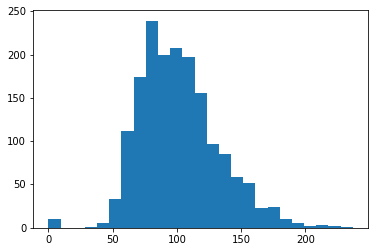

In [36]:
plt.hist(df['value'], bins=25)
plt.show()

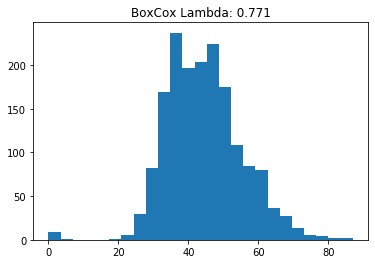

In [37]:
df['adj_value'], boxcox_lambda = boxcox(df['value']+1)
plt.hist(df['adj_value'], bins=25)
title = 'BoxCox Lambda: {:.3f}'.format(boxcox_lambda)
plt.title(title)
plt.show()

---

## Auxiliary Functions

In [39]:
def mape(df, actual, model):
    diff = df[actual] - df[model]
    return np.mean(abs(diff/df[actual]))

In [40]:
def plot_model(train, test, model):
    plt.figure(figsize=(12, 6))
    plt.plot(train[metric], label='train')
    plt.plot(test[metric], label='test: actual')
    plt.plot(test[model], label='test: '+model)
    cmape = mape(test, metric, model)
    title = 'Model: ' + model + ' (MAPE: ' + str(round(cmape, 4)) + ')'
    plt.title(title, fontsize=15)
    plt.legend()
    plt.show()

In [38]:
def train_test_split(df, split):
    n_split = int(df.shape[0]*split)
    train = df[:n_split]
    test = df[n_split:]
    return train, test

---

## Monthly Model: without exogenous variables

In [39]:
df.head()

,id,item_id,store_id,value,date,wm_yr_wk,weekday,month,year,holiday,sell_price,weeknum,adj_value
0,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,144,2011-09-01,11131,3_Thu,9,2011,0,1.48,35,58.922000
1,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,147,2011-09-02,11131,4_Fri,9,2011,0,1.48,35,59.880625
2,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,177,2011-09-03,11132,5_Sat,9,2011,0,1.48,35,69.239334
3,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,88,2011-09-04,11132,6_Sun,9,2011,0,1.48,35,40.031591
4,FOODS_3_586_TX_2_validation,FOODS_3_586,TX_2,138,2011-09-05,11132,0_Mon,9,2011,LaborDay,1.48,36,56.990987


In [40]:
dfc = df.drop(['id', 'item_id', 'store_id', 'wm_yr_wk', 'year', 'weeknum'], axis=1).copy()

In [41]:
min_date = dfc['date'].min()
dfc['dt'] = df['date'].apply(lambda x: (x-min_date).days)
dfc['dt2'] = dfc['dt']**2
dfc.set_index('date', inplace=True)

In [42]:
df_dummies = pd.get_dummies(dfc, columns=['weekday', 'month', 'holiday'], drop_first=True)
df_dummies.head()

,value,sell_price,adj_value,dt,dt2,weekday_1_Tue,weekday_2_Wed,weekday_3_Thu,weekday_4_Fri,weekday_5_Sat,...,holiday_IndependenceDay,holiday_LaborDay,holiday_Mother's day,holiday_NBAFinalsEnd,holiday_NBAFinalsStart,holiday_NewYear,holiday_Ramadan starts,holiday_SuperBowl,holiday_Thanksgiving,holiday_ValentinesDay
date,,,,,,,,,,,,,,,,,,,,,
2011-09-01,144,1.48,58.922000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-09-02,147,1.48,59.880625,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2011-09-03,177,1.48,69.239334,2,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2011-09-04,88,1.48,40.031591,3,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-09-05,138,1.48,56.990987,4,16,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [43]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_dummies.drop('value', axis=1))

In [44]:
X_std = pd.DataFrame(X_std, columns=df_dummies.drop('value', axis=1).columns, index=df_dummies.index)

In [45]:
X_std.head()

,sell_price,adj_value,dt,dt2,weekday_1_Tue,weekday_2_Wed,weekday_3_Thu,weekday_4_Fri,weekday_5_Sat,weekday_6_Sun,...,holiday_IndependenceDay,holiday_LaborDay,holiday_Mother's day,holiday_NBAFinalsEnd,holiday_NBAFinalsStart,holiday_NewYear,holiday_Ramadan starts,holiday_SuperBowl,holiday_Thanksgiving,holiday_ValentinesDay
date,,,,,,,,,,,,,,,,,,,,,
2011-09-01,-2.017477,1.336108,-1.731031,-1.117664,-0.407687,-0.407687,2.446968,-0.408669,-0.408669,-0.408669,...,-0.048593,-0.054345,-0.048593,-0.048593,-0.048593,-0.054345,-0.048593,-0.054345,-0.054345,-0.054345
2011-09-02,-2.017477,1.424509,-1.728991,-1.117663,-0.407687,-0.407687,-0.408669,2.446968,-0.408669,-0.408669,...,-0.048593,-0.054345,-0.048593,-0.048593,-0.048593,-0.054345,-0.048593,-0.054345,-0.054345,-0.054345
2011-09-03,-2.017477,2.287527,-1.726951,-1.117659,-0.407687,-0.407687,-0.408669,-0.408669,2.446968,-0.408669,...,-0.048593,-0.054345,-0.048593,-0.048593,-0.048593,-0.054345,-0.048593,-0.054345,-0.054345,-0.054345
2011-09-04,-2.017477,-0.405880,-1.724911,-1.117653,-0.407687,-0.407687,-0.408669,-0.408669,-0.408669,2.446968,...,-0.048593,-0.054345,-0.048593,-0.048593,-0.048593,-0.054345,-0.048593,-0.054345,-0.054345,-0.054345
2011-09-05,-2.017477,1.158039,-1.722871,-1.117645,-0.407687,-0.407687,-0.408669,-0.408669,-0.408669,-0.408669,...,-0.048593,18.401087,-0.048593,-0.048593,-0.048593,-0.054345,-0.048593,-0.054345,-0.054345,-0.054345


In [46]:
lr = LinearRegression()

In [47]:
lr.fit(X=X_std, y=df_dummies['value'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
y_pred = lr.predict(X_std)

In [49]:
y_pred.shape

(1698,)

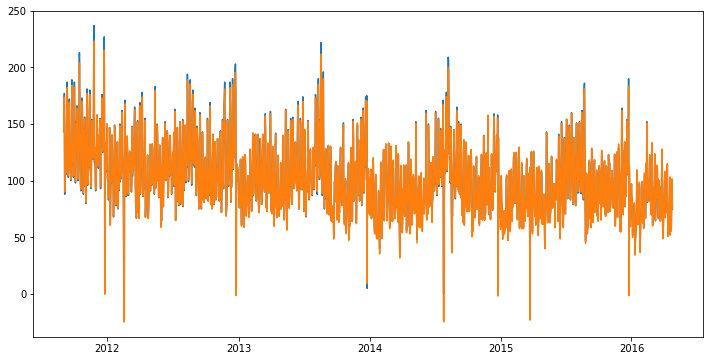

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(df_dummies['value'])
plt.plot(df_dummies.index, y_pred)
plt.show()

In [51]:
diff = (y_pred - df_dummies['value'])
mae = np.mean(abs(diff))

In [52]:
mae

1.0067111996197498

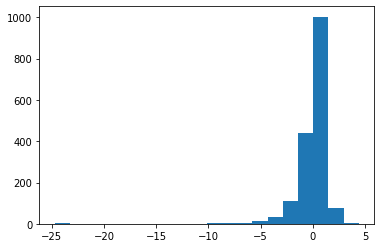

In [53]:
plt.hist(diff, bins=20)
plt.show()

In [54]:
coeff = pd.DataFrame(lr.coef_, index=X_std.columns)
coeff

,0
sell_price,-0.170385
adj_value,30.886796
dt,-0.639372
dt2,0.592153
weekday_1_Tue,0.015460
weekday_2_Wed,-0.015379
weekday_3_Thu,0.000843
weekday_4_Fri,0.078163
weekday_5_Sat,0.417105
weekday_6_Sun,0.304095


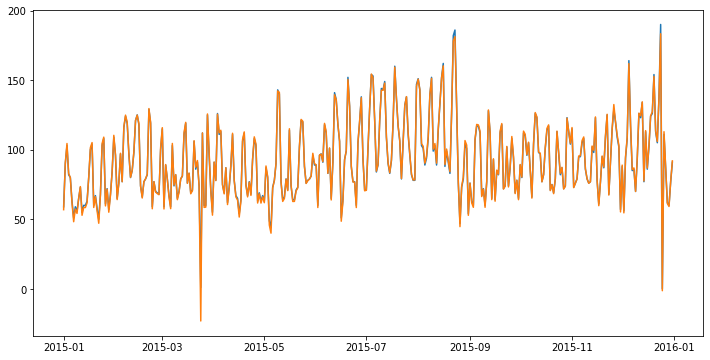

In [55]:
flag = df_dummies.index.year==2015
plt.figure(figsize=(12, 6))
plt.plot(df_dummies[flag]['value'])
plt.plot(df_dummies[flag].index, y_pred[flag])
plt.show()